In [1]:
# Audio processing
!pip install librosa soundfile

# Data handling
!pip install pandas numpy scikit-learn

# Optional: visualization
!pip install matplotlib seaborn

In [6]:
!pip install librosa soundfile pandas numpy scikit-learn matplotlib seaborn

In [14]:
import os
import glob
import librosa
import numpy as np
import pandas as pd
data_path = "IRMAS-TrainingData"
for root, dirs, files in os.walk(data_path):
    print(root, len(files))

IRMAS-TrainingData 0
IRMAS-TrainingData\IRMAS-TrainingData 1
IRMAS-TrainingData\IRMAS-TrainingData\cel 388
IRMAS-TrainingData\IRMAS-TrainingData\cla 505
IRMAS-TrainingData\IRMAS-TrainingData\flu 451
IRMAS-TrainingData\IRMAS-TrainingData\gac 637
IRMAS-TrainingData\IRMAS-TrainingData\gel 760
IRMAS-TrainingData\IRMAS-TrainingData\org 682
IRMAS-TrainingData\IRMAS-TrainingData\pia 721
IRMAS-TrainingData\IRMAS-TrainingData\sax 626
IRMAS-TrainingData\IRMAS-TrainingData\tru 577
IRMAS-TrainingData\IRMAS-TrainingData\vio 580
IRMAS-TrainingData\IRMAS-TrainingData\voi 778


In [15]:
dataset = []

# Walk through all folders and find .wav files
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.lower().endswith(".wav"):   # catches both .wav and .WAV
            label = os.path.basename(root)  # folder name = label
            file_path = os.path.join(root, file)
            dataset.append((file_path, label))

print("Total files:", len(dataset))
if dataset:
    print("Example:", dataset[0])
else:
    print("⚠️ No files found. Check path or extension.")

Total files: 6705
Example: ('IRMAS-TrainingData\\IRMAS-TrainingData\\cel\\008__[cel][nod][cla]0058__1.wav', 'cel')


In [18]:
# Example: load first audio file
file_path, label = dataset[0]
y, sr = librosa.load(file_path, sr=None)

print("Label:", label)
print("Audio shape:", y.shape)
print("Sample rate:", sr)

Label: cel
Audio shape: (132299,)
Sample rate: 44100


In [23]:
import librosa
import numpy as np

SAMPLE_RATE = 22050
DURATION = 3       # seconds
SAMPLES = SAMPLE_RATE * DURATION

def preprocess_audio(file_path):
    # 1. Load audio (mono)
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)

    # Avoid trim for IRMAS (causes hangs)
    # 2. Trim silence
    #y, _ = librosa.effects.trim(y, top_db=20)

    # 3. Fix length (pad or cut)
    if len(y) < SAMPLES:
        y = np.pad(y, (0, SAMPLES - len(y)))
    else:
        y = y[:SAMPLES]

    # 4. Normalize audio
    y = librosa.util.normalize(y)

    # 5. Mel Spectrogram
    mel = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=2048,
        hop_length=512,
        n_mels=128
    )

    # 6. Convert to log scale
    mel_db = librosa.power_to_db(mel, ref=np.max)

    return mel_db


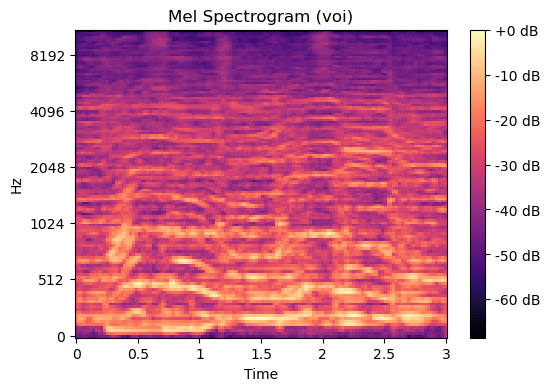

In [24]:
import librosa.display
import matplotlib.pyplot as plt

mel_spec = preprocess_audio(file_path)

plt.figure(figsize=(6,4))
librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel')
plt.colorbar(format="%+2.0f dB")
plt.title(f"Mel Spectrogram ({label})")
plt.show()


In [41]:
#CREATE OUTPUT FOLDER
import os

SAVE_DIR = "spectrogram_images"

os.makedirs(SAVE_DIR, exist_ok=True)


In [42]:
#FUNCTION TO SAVE MEL-SPECTROGRAM AS IMAGE
import matplotlib.pyplot as plt
import librosa.display

def save_spectrogram_image(mel_db, save_path):
    plt.figure(figsize=(3, 3))   # small image, CNN-friendly
    librosa.display.specshow(
        mel_db,
        x_axis=None,
        y_axis=None,
        cmap="magma"
    )
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.savefig(save_path, dpi=100, bbox_inches='tight', pad_inches=0)
    plt.close()


In [43]:
"""Convert all audio files into:
X → spectrograms
y → numeric labels
"""
#SAVE SPECTROGRAMS WHILE PROCESSING DATASET
#Now you’ll  if you see output every 100 files, so it will never feel “stuck”. if you did with all files then it will definately stuck

X = []
y = []

label_map = {}
label_id = 0

print("Starting dataset processing & image saving")

for i, (file_path, label) in enumerate(dataset):

    if i % 100 == 0:
        print(f"Processed {i} files")

    mel = preprocess_audio(file_path)

    if mel.shape[1] < 128:
        continue

    mel = mel[:, :128]

    # ----- SAVE IMAGE -----
    if label not in label_map:
        label_map[label] = label_id
        label_id += 1

    image_name = f"{label}_{i}.png"
    image_path = os.path.join(SAVE_DIR, image_name)

    save_spectrogram_image(mel, image_path)

    # ----- STORE FOR CNN -----
    X.append(mel)
    y.append(label_map[label])

print("Finished processing")
print("Images saved in:", SAVE_DIR)



Starting dataset processing & image saving
Processed 0 files
Processed 100 files
Processed 200 files
Processed 300 files
Processed 400 files
Processed 500 files
Processed 600 files
Processed 700 files
Processed 800 files
Processed 900 files
Processed 1000 files
Processed 1100 files
Processed 1200 files
Processed 1300 files
Processed 1400 files
Processed 1500 files
Processed 1600 files
Processed 1700 files
Processed 1800 files
Processed 1900 files
Processed 2000 files
Processed 2100 files
Processed 2200 files
Processed 2300 files
Processed 2400 files
Processed 2500 files
Processed 2600 files
Processed 2700 files
Processed 2800 files
Processed 2900 files
Processed 3000 files
Processed 3100 files
Processed 3200 files
Processed 3300 files
Processed 3400 files
Processed 3500 files
Processed 3600 files
Processed 3700 files
Processed 3800 files
Processed 3900 files
Processed 4000 files
Processed 4100 files
Processed 4200 files
Processed 4300 files
Processed 4400 files
Processed 4500 files
Pro

In [44]:
#SAFE NUMPY CONVERSION
import numpy as np

X = np.stack(X)     # safer than np.array
y = np.array(y)

X = X[..., np.newaxis]
X = X / np.max(X)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (6705, 128, 128, 1)
y shape: (6705,)


In [45]:
import pandas as pd
import os

IMAGE_DIR = "spectrogram_images"

rows = []

for image_name in os.listdir(IMAGE_DIR):

    if not image_name.lower().endswith(".png"):
        continue

    # Extract label from filename: piano_23.png → piano
    label = image_name.split("_")[0]

    row = {
        "image_path": os.path.join(IMAGE_DIR, image_name),
        "label": label,
        "label_id": label_map[label]
    }

    rows.append(row)

# Create DataFrame
df = pd.DataFrame(rows)

# Save CSV
df.to_csv("spectrogram_labels.csv", index=False)

print("✅ CSV file created successfully!")
print(df.head())


✅ CSV file created successfully!
                       image_path label  label_id
0    spectrogram_images\cel_0.png   cel         0
1    spectrogram_images\cel_1.png   cel         0
2   spectrogram_images\cel_10.png   cel         0
3  spectrogram_images\cel_100.png   cel         0
4  spectrogram_images\cel_101.png   cel         0
